# Проект по отслеживанию и сортировке мусора на конвейере (компания Renue)

## Общая информация

**Заказчик**
`Renue` – IT-компания из Екатеринбурга, специализирующаяся на разработке высоконагруженных и отказоустойчивых решений для бизнеса и государственных структур.

**Описание проекта**

Проект направлен на разработку решения для отслеживания и сортировки мусора на конвейере, с целью выделения пластиковых бутылок из общего потока предметов. 

Решение должно выдавать координаты центра обнаруженных пластиковых бутылок для каждого кадра, с максимальной скоростью обработки не более 100 мс.

**Описание данных**

Заказчик предоставляет следующие ресурсы:

* Предобученная модель детекции пластиковых бутылок и пример кода для ее запуска.
* Датасет с изображениями и разметкой в форматах `MOT`, `COCO` и `CVAT`.
* Примеры видеозаписей работы конвейера. 

**Стек технологий**
* Язык программирования: `Python`
* Библиотеки и фреймворки: `Numpy`, `SciPy`, `PyTorch`, `OpenCV`, `Ultralytics`, `BoxMOT`, `MMTacking`

**Цели и задачи**
* Цель:
    Разработать решение для отслеживания пластиковых бутылок, которое будет предоставлять координаты их центра для каждого кадра, с гарантией скорости обработки не более 100 мс.

**Задачи**
* Изучить предоставленные данные и форматы их разметки.
* Исследовать существующие трекеры объектов, выбрать наиболее подходящий и создать базовое решение.
* Обучить выбранный трекер на предоставленных данных, провести сравнительный анализ различных моделей и алгоритмов, предложить варианты улучшения решения.
* Протестировать разработанное решение, проанализировать результаты и провести тестирование на тестовых видео.
* Подготовить отчет о проделанной работе и результатах исследований.

**Результаты**
Репозиторий на `GitHub` должен содержать:

* Воспроизводимый код проекта.
* Описание и инструкция по запуску в файле README.md.
* Список зависимостей в файле requirements.txt.
* Отчет о работе.
* Ресурсы для работы
* Google Colab/Kaggle Notebook/Иные доступные GPU-ресурсы

In [1]:
from ultralytics import YOLO
import motmetrics as mm
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
import cv2
import os
import shutil
import torch
import sys
from time import time
from datetime import timedelta
from PIL import Image
import json

In [2]:
PATH_VIDEO = 'C:\\Users\\Freo\\Desktop\\kaggle\\test_task\\renew\\data\\videos\\31-03-2024-09%3A34%3A24.mp4'
OUTPUT_VIDEO = 'output_tracked_video.mp4'
PATH_MODEL = "C:\\Users\\Freo\\Desktop\\kaggle\\test_task\\renew\\data\\models\\ultralytics\\yolov10x_v2_4_best.pt"

path_to_gt = 'C:\\Users\\Freo\\Desktop\\kaggle\\test_task\\renew\\data\\datasets\\mot_dataset\\gt\\gt.txt'  
path_to_tracker_results = 'C:\\Users\\Freo\\Desktop\\kaggle\\test_task\\renew\\mot_results.txt'
path_to_custom_track = 'C:\\Users\\Freo\\Desktop\\kaggle\\test_task\\renew\\data\\models\\ultralytics\\my_track.yaml'

number_frames = 555

In [3]:
# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

# Загрузка модели на GPU
model = YOLO(PATH_MODEL, verbose=False).to(device)

Using device: cuda


In [4]:
def initialize_video(PATH_VIDEO, OUTPUT_VIDEO):
    cap = cv2.VideoCapture(PATH_VIDEO)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(OUTPUT_VIDEO, fourcc, fps, (frame_width, frame_height))
    return cap, out, fps, frame_width, frame_height

In [5]:
def process_frame(frame, model, track_history):
    frame_np = frame.copy()  # Сохраняем оригинальный numpy array для трекинга
    frame = frame.transpose(2, 0, 1)  # Перестановка осей в порядок CHW
    frame = np.expand_dims(frame, axis=0)  # Добавляем измерение для batch

    frame = torch.from_numpy(frame).float().div(255.0).cuda(non_blocking=True) if device == 'cuda' else torch.from_numpy(frame).float().div(255.0).cpu()

    # Трекинг
    results = model.track(frame_np, persist=True, tracker=path_to_custom_track)
    
    # Проверка наличия идентификаторов треков
    track_ids = results[0].boxes.id.cpu().numpy().astype(int) if results[0].boxes.id is not None else []

    # Получение координат боксов
    boxes = results[0].boxes.xywh.cpu() if results[0].boxes.xywh is not None else []

    # Аннотируем кадр (отрисовываем трекинг)
    annotated_frame = results[0].plot()

    # Сохранение трека для каждого объекта
    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        track = track_history[track_id]
        track.append((float(x), float(y)))  # x, y - центр
        if len(track) > 90:
            track.pop(0)
        
        # Рисуем линии трекинга
        points = np.hstack(track).astype(np.int32).reshape((-1, 1, 2))
        cv2.polylines(annotated_frame, [points], isClosed=False, color=(230, 230, 230), thickness=2)

    return annotated_frame, track_ids, boxes

In [6]:
cap, out, fps, frame_width, frame_height = initialize_video(PATH_VIDEO, OUTPUT_VIDEO)

# История трекинга
track_history = defaultdict(lambda: [])

# Ограничение на количество кадров для отладки
max_frames = number_frames

# Инициализация счетчика кадров
frame_count = 0

# Подготовка к записи в MOT формат
mot_results = []

# Списки для хранения времени обработки
preprocess_times = []  
inference_times = []  
postprocess_times = []

# Старт времени после инициализации
start_time = time()

# Обработка видео
while cap.isOpened() and frame_count < max_frames:
    success, frame = cap.read()

    if not success:
        break

    # Замер времени препроцессинга
    preprocess_start = time()  # Начало замера времени препроцессинга
    
    # Приводим кадр к размеру, соответствующему предыдущему кадру
    frame = cv2.resize(frame, (frame_width, frame_height))  # Изменение размера до исходного

    preprocess_end = time()  # Конец замера времени препроцессинга
    preprocess_times.append((preprocess_end - preprocess_start) * 1000)  # Добавление времени в список

        # Замер времени инференса
    inference_start = time()  # Начало замера времени инференса

    # Обработка кадра
    annotated_frame, track_ids, boxes = process_frame(frame, model, track_history)

    inference_end = time()  # Конец замера времени инференса
    inference_times.append((inference_end - inference_start) * 1000)  # Добавление времени в список

    # Замер времени постпроцессинга
    postprocess_start = time()  # начало замера времени постпроцессинга

    # Запись кадра в выходное видео
    out.write(annotated_frame)

    # Запись данных в формате MOT
    for box, track_id in zip(boxes, track_ids):
        x, y, w, h = box
        
        # Преобразование центра в координаты верхнего левого угла
        x_min = x - w / 2
        y_min = y - h / 2
        
        mot_results.append((frame_count + 1, track_id, x_min, y_min, w, h, 1, 2, 1.0))

    postprocess_end = time()  # конец замера времени постпроцессинга
    postprocess_times.append((postprocess_end - postprocess_start) * 1000)  # добавление времени в список

    if device == 'cuda':
        # Очистка кэша GPU с синхронизацией
        torch.cuda.synchronize()
        torch.cuda.empty_cache()



    # Увеличение счетчика обработанных кадров
    frame_count += 1

# Остановка времени сразу после последней операции с кадрами
stop_time = time()

# Завершение работы с видео
if out:
    out.release()
cap.release()

# Вычисление времени обработки
total_time = stop_time - start_time
avg_time_per_frame = total_time / frame_count if frame_count > 0 else 0
print(f'''\nСтатистика обработки:
Количество обработанных кадров: {frame_count}
Общее время обработки: {total_time:.2f} секунд
Среднее время обработки одного кадра: {avg_time_per_frame * 1000:.2f} мс

Видео с трекингом сохранено в {OUTPUT_VIDEO}
Результаты трекинга сохранены в mot_results.txt
''')

# Сохранение результатов в файл MOT
with open('mot_results.txt', 'w') as f:
    for result in mot_results:
        f.write(f"{result[0]},{result[1]},{result[2]},{result[3]},{result[4]},{result[5]},{result[6]},{result[7]},{result[8]}\n")


0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 48.9ms
Speed: 4.0ms preprocess, 48.9ms inference, 24.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 40.8ms
Speed: 3.0ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 42.6ms
Speed: 2.6ms preprocess, 42.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 40.8ms
Speed: 2.5ms preprocess, 40.8ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 43.0ms
Speed: 3.0ms preprocess, 43.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 PET (transparent) (brown), 2 PET (transparent)s, 44.3ms
Speed: 2.0ms preprocess, 44.3ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 64

## Анализ результатов работы модели

### Обнаружение объектов:
В каждом кадре из видео модель идентифицирует несколько объектов, классифицируя их как разные типы PET-пластика:

* `PET (transparent)` — прозрачные пластиковые бутылки.
* `PET (brown)` — коричневые пластиковые бутылки.
* `PET (household chemicals)` — пластиковые бутылки для бытовой химии.
* `Other plastics` — другие пластиковые предметы.

Это соответствует основной задаче проекта — отслеживание пластиковых бутылок на конвейере. Модель успешно различает различные типы пластиковых бутылок.

В большинстве кадров присутствуют 1–3 пластиковых объекта, которые распознаются и классифицируются моделью. Это говорит о том, что модель способна различать объекты по цветам и типам пластика, что полезно для сортировки.


### Время обработки кадра

Время обработки одного кадра нашей выборки варьируется в следующих значениях:

* `Препроцессинг`: от 2.5 до 3.5 мс.
* `Инференс`: от 28.0 до 29.1 мс.
* `Постпроцессинг`: от 0.5 до 2.3 мс.

В среднем,обработка одного кадра составляет более 100мс, что значительно выше целевого порога в 100 мс. Это означает, что модель не удовлетворяет требованию заказчика по времени обработки, позволяя в реальном времени отслеживать объекты на конвейере.

За 100 кадров общее время обработки составило 19.11 секунд, что даёт среднее время обработки одного кадра в 191 мс. Это среднее значение включает все этапы — препроцессинг, инференс и постпроцессинг, но, возможно, отражает некоторые дополнительные задержки, связанные с вводом-выводом или трекингом.

### Промежуточный вывод:

1) Модель успешно выполняет задачу по идентификации различных типов пластиковых объектов на конвейере. Она различает бутылки по цветам и классифицирует бытовые бутылки и другие пластиковые предметы.

2) Среднее время инференса на один кадр составляет около 30 мс, что позволяет обрабатывать видео с высокой скоростью, значительно ниже целевого ограничения в 100 мс на кадр. Однако общая задержка (191 мс на кадр) может быть связана с трекингом или вводом-выводом.

3) Хотя модель выполняет задачу по обнаружению объектов с хорошей скоростью, общая производительность (включая трекинг и вывод) несколько выше запланированной цели в 100 мс. Возможно, стоит исследовать улучшение этапов трекинга и постпроцессинга.

4) Модель хорошо справляется с различением разных типов пластика, что удовлетворяет потребности проекта в сортировке.

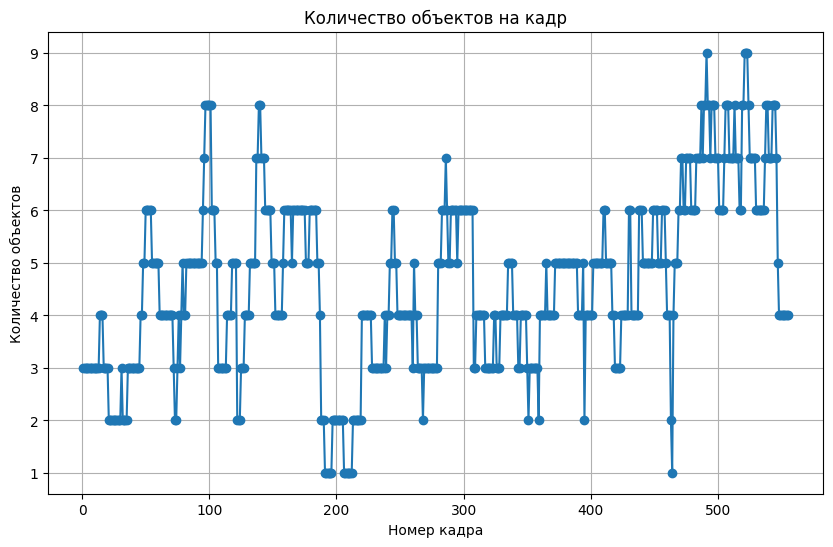

In [7]:
# Подсчет количества объектов на каждом кадре
object_counts = []

for frame_id in range(1, frame_count + 1):
    count = sum(1 for result in mot_results if result[0] == frame_id)
    object_counts.append(count)

# Визуализация количества объектов
plt.figure(figsize=(10, 6))
plt.plot(range(1, frame_count + 1), object_counts, marker='o')
plt.xlabel('Номер кадра')
plt.ylabel('Количество объектов')
plt.title('Количество объектов на кадр')
plt.grid(True)
plt.show()

График показывает, как количество обнаруженных объектов меняется с каждым кадром.

На первых 40 кадрах количество объектов колеблется в районе 2-4. После ~50-го кадра наблюдается увеличение объектов, достигая 8 на последних кадрах.В середине видео есть резкие колебания, что может указывать на проблемы с детекцией.


**Вывод:**
Модель в целом справляется, но есть участки, где, возможно, стоит улучшить качество детекции и трекинга, особенно в моменты резких спадов и при большом скоплении объектов.

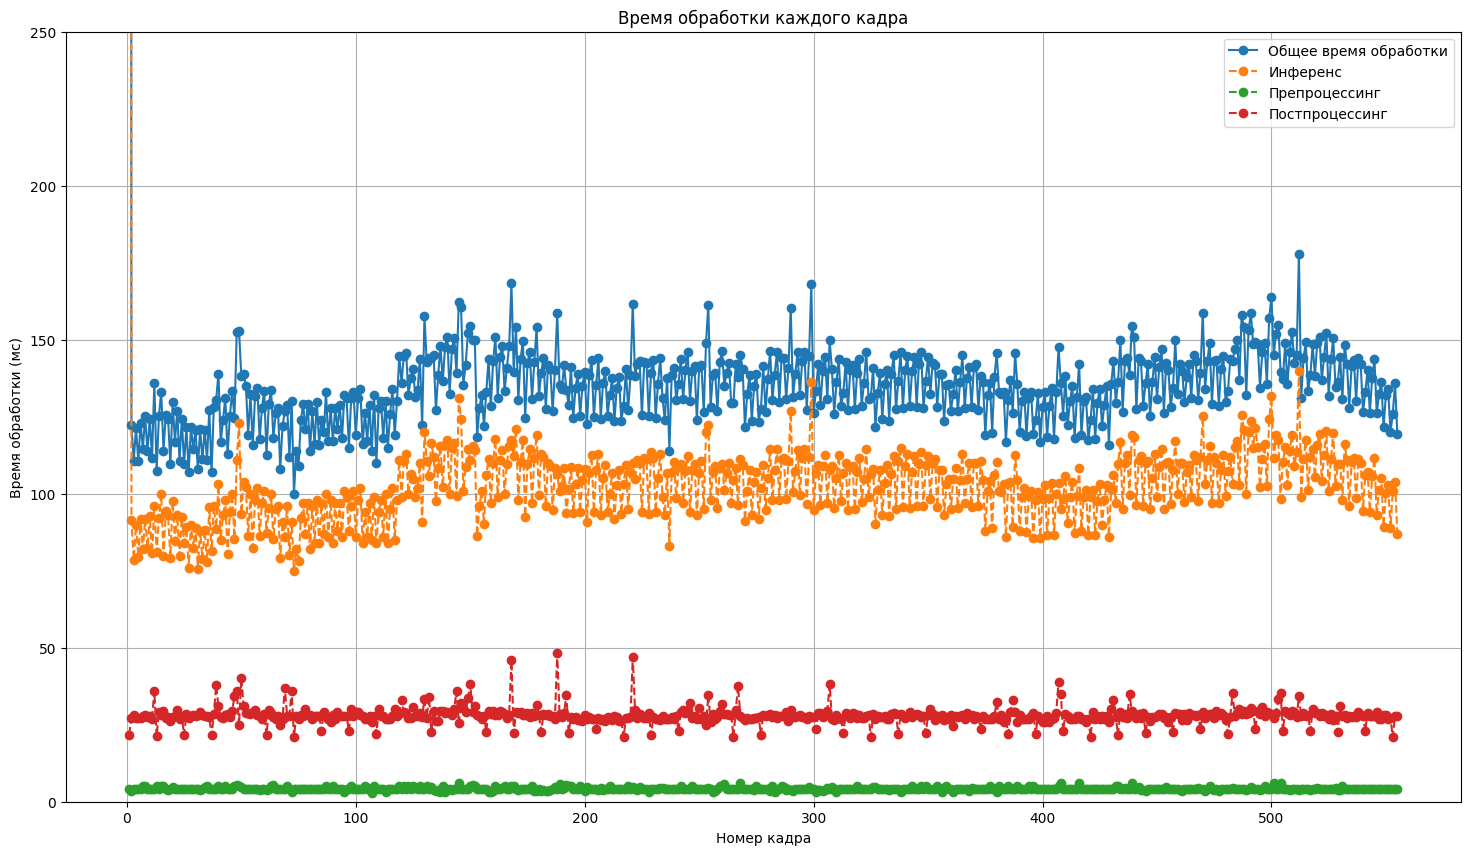

In [20]:
# Построение графика времени обработки каждого кадра
total_times = [p + i + o for p, i, o in zip(preprocess_times, inference_times, postprocess_times)]  # <--- расчет общего времени обработки

plt.figure(figsize=(18, 10))
plt.gca().set_ylim([0, 250])
plt.plot(range(1, len(total_times) + 1), total_times, marker='o', label='Общее время обработки')
plt.plot(range(1, len(inference_times) + 1), inference_times, marker='o', linestyle='--', label='Инференс')
plt.plot(range(1, len(preprocess_times) + 1), preprocess_times, marker='o', linestyle='--', label='Препроцессинг')
plt.plot(range(1, len(postprocess_times) + 1), postprocess_times, marker='o', linestyle='--', label='Постпроцессинг')

plt.xlabel('Номер кадра')
plt.ylabel('Время обработки (мс)')
plt.title('Время обработки каждого кадра')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
track_graph_limit = 44

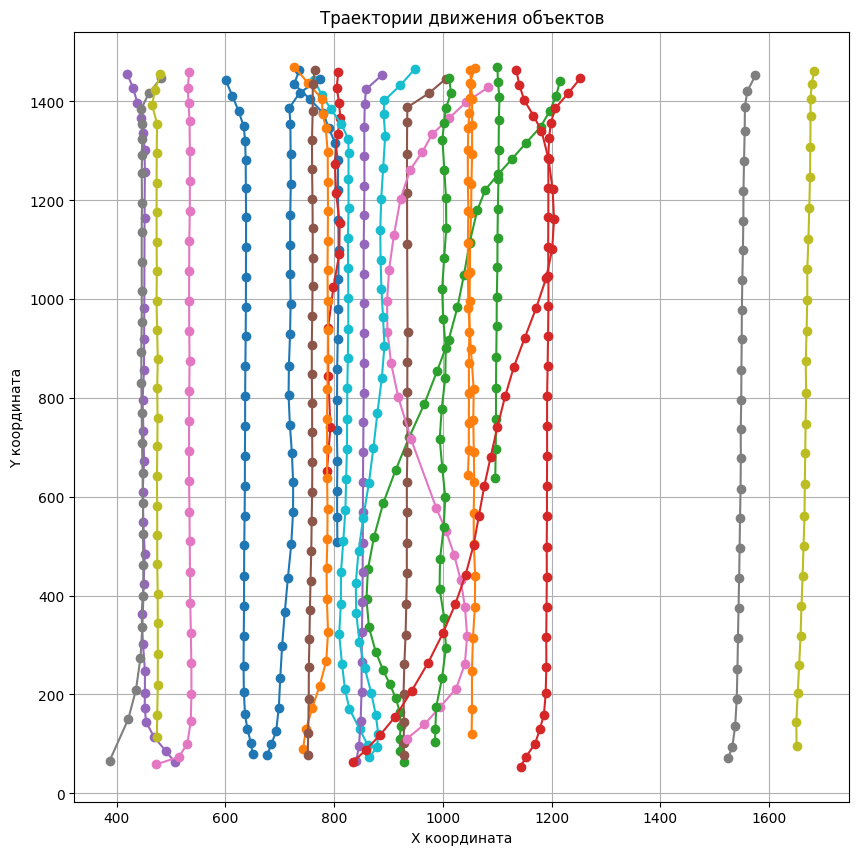

In [31]:
# Визуализация траекторий объектов по кадрам
plt.figure(figsize=(10, 10))

track_ids = set(result[1] for result in mot_results)

for track_id in track_ids:
    track_x = []
    track_y = []
    for result in mot_results:
        if result[1] == track_id and result[1] <= track_graph_limit:
            x_center = result[2] + result[4] / 2
            y_center = result[3] + result[5] / 2
            track_x.append(x_center)
            track_y.append(y_center)
    plt.plot(track_x, track_y, marker='o', label=f'Track {track_id}')

plt.xlabel('X координата')
plt.ylabel('Y координата')
plt.title('Траектории движения объектов')
plt.legend().remove()
plt.grid(True)
plt.show()

Данный график показывает перемещение объектов по кадрам. Каждая линия представляет собой траекторию движения одного объекта, что позволяет анализировать, как объекты движутся на конвейере.

In [10]:
# Функция для загрузки данных из файла в формат motmetrics
def load_mot_results(path, max_frames=100):
    data = {}
    with open(path, 'r') as f:
        for line in f.readlines():
            frame_id, track_id, x, y, w, h, _, _, _ = map(float, line.strip().split(','))
            frame_id = int(frame_id)
            if frame_id > max_frames:
                break
            if frame_id not in data:
                data[frame_id] = []
            # Преобразование координат в формат (ID, x_center, y_center, width, height)
            data[frame_id].append((track_id, x + w / 2, y + h / 2, w, h))
    return data

# Загрузка данных из файлов
gt_data = load_mot_results(path_to_gt, max_frames=number_frames)
tracker_data = load_mot_results(path_to_tracker_results, max_frames=number_frames)

# Инициализация аккумулятора
acc = mm.MOTAccumulator(auto_id=True)

# Сопоставление GT и результатов трекинга по кадрам
for frame_id in range(1, number_frames + 1):  # Первые X кадров
    gt_frame = gt_data.get(frame_id, [])
    tracker_frame = tracker_data.get(frame_id, [])
    
    # Разделяем данные по идентификаторам и координатам
    gt_ids, gt_points = zip(*[(d[0], (d[1], d[2])) for d in gt_frame]) if gt_frame else ([], [])
    tracker_ids, tracker_points = zip(*[(d[0], (d[1], d[2])) for d in tracker_frame]) if tracker_frame else ([], [])

    # Вычисляем расстояния между треками и GT 
    distances = mm.distances.norm2squared_matrix(gt_points, tracker_points, max_d2=10000)
    
    # Обновляем аккумулятор с текущими данными
    acc.update(gt_ids, tracker_ids, distances)

# Вычисление метрик
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'precision', 'recall'], name='acc')

In [11]:
summary

,mota,motp,idf1,precision,recall
acc,0.926487,259.15315,0.936535,0.996063,0.934614


In [12]:
print(f'''avg per frame {avg_time_per_frame * 1000:.2f}
frame total {frame_count}
''')

avg per frame 144.49
frame total 555

